<h1 style = "text-align: center">Data Preparation</h1>

<h3 style = "text-align: center">Food.com Recipe Recommender - SOEN 471 (Big Data Analytics)</h3>


## Objective:

Inspect the dataset, identify missing data, outliers, data types (categorical data in particular), and write Dask programs to correct for potential issues. Finally, return training and testing datasets to be used to create and test recommendation engines.

In [1]:
import os
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
interactions = dd.read_csv('RAW_interactions.csv')
recipes = dd.read_csv('RAW_recipes.csv')

## Sample Tuples:


In [3]:
interactions.dtypes

user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

In [4]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [5]:
recipes = recipes.rename(columns={"id": "recipe_id"})
recipes.dtypes

name              object
recipe_id          int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

In [6]:
recipes.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


The `nutrition` column in the recipes dataframe contains a list of 7 (nutritional) values. Instead of moving forward with this column - a better approach is to change this column to be in 1NF (1st normal form). The values corresponding to the list are as follows:
- Calories
- Total Fat (PDV)
- Sugar (PDV)
- Sodium (PDV)
- Protein (PDV)
- Saturated fat (PDV)
- Carbohydrates (PDV)

## Normalizing Column(s)

In [7]:
def normalize_columns(recipes_df, column_to_normalize):
    
    """
    Normalize the column_to_normalize column in recipes dataframe
    
    recipes_df: Dask Dataframe object in which normalization is to be applied
    column_to_normalize: Name of the column that is to be normalized
    """
    
    recipes_df[column_to_normalize] = recipes_df[column_to_normalize].map(lambda x: x.split(','))  

    recipes_df = recipes_df.assign(Calories = recipes_df[column_to_normalize].map(lambda x: x[0], meta = ('Calories', str)),
                                   Total_fat_PDV = recipes_df[column_to_normalize].map(lambda x: x[1], meta = ('Total_fat_PDV', str)),
                                   Sugar_PDV = recipes_df[column_to_normalize].map(lambda x: x[2], meta = ('Sugar_PDV', str)),
                                   Sodium_PDV = recipes_df[column_to_normalize].map(lambda x: x[3], meta = ('Sodium_PDV', str)),
                                   Protein_PDV = recipes_df[column_to_normalize].map(lambda x: x[4], meta = ('Protein_PDV', str)),
                                   Saturated_fat_PDV = recipes_df[column_to_normalize].map(lambda x: x[5], meta = ('Saturated_fat_PDV', str)),
                                   Carbohydrates_PDV = recipes_df[column_to_normalize].map(lambda x: x[6], meta = ('Carbohydrates_PDV', str)))
    
    recipes_df['Calories'] = recipes_df['Calories'].map(lambda x: x[1:])
    recipes_df['Carbohydrates_PDV'] = recipes_df['Carbohydrates_PDV'].map(lambda x: x[:len(x)-1])
    
    recipes_df = recipes_df.drop([column_to_normalize], axis=1)
    
    return recipes_df

## Identifying Missing / Repeated Values

In [8]:
def missing_values_check(dask_df):
    
    """
    Checks if there are any missing values in dask_df
    
    dask_df: Dask Dataframe object in which missing values are searched for
    """
    
    return dask_df.isnull().any().rename('MissingValues?').to_frame()

In [9]:
def repeat_values_removal(dask_df):
    
    """
    Drops any repeated rows in dask_df
    
    dask_df: Dask Dataframe object in which repeated rows are dropped
    """
    
    return dask_df.drop_duplicates()

In [10]:
missing_values_check(recipes).compute()

,MissingValues?
name,True
recipe_id,False
minutes,False
contributor_id,False
submitted,False
tags,False
nutrition,False
n_steps,False
steps,False
description,True


In [11]:
missing_values_check(interactions).compute()

,MissingValues?
user_id,False
recipe_id,False
date,False
rating,False
review,True


For the project use case, where two different recommender engines are to be engineered - it does not make much sense for those (recommendation) models to recommend recipes that have no name. Similarly, there are also recommendations with missing descriptions. However, it is reasonable for the recommendation models to return recipes with missing descriptions.

As for the interactions dataset, the only column with missing values is the review column. Given that the recommendation models will make recommendations based on user ratings - having missing reviews should not be a problem.

The approach used to handle missing values (recipe names) will be to drop them from both datasets. For example if `recipe_id = 905` is missing its name, then all `recipe_id = 905` tuples from the interactions dataset will also be dropped.

## Handling Missing / Repeated Values

In [12]:
def remove_invalid_recipes(recipe_df, interaction_df):
    """
    Remove all recipes from both dataframes which are missing their name
    
    recipe_df: Dask Dataframe object in which recipe information is contained
    interaction_df: Dask Dataframe object in which ratings information is contained
    """
    
    null_name_recipes = list(recipe_df[recipe_df['name'].isnull()]['recipe_id'].compute())
    
    interaction_df = interaction_df[~interaction_df['recipe_id'].isin(null_name_recipes)]
    recipe_df = recipe_df[~recipe_df['recipe_id'].isin(null_name_recipes)]

    return (recipe_df, interaction_df)

In [13]:
recipes, interactions = remove_invalid_recipes(recipes, interactions)
recipes = normalize_columns(recipes, 'nutrition')
recipes = repeat_values_removal(recipes)
interactions = repeat_values_removal(interactions)

## Create train / test splits

In [14]:
# Converts dask df to pandas df
recipes = recipes.compute()
interactions = interactions.compute()

In [15]:
interactions_TRAIN, interactions_TEST = train_test_split(interactions, test_size=0.1, random_state = 0)

In [16]:
print('Training Set: ', interactions_TRAIN.shape)
print('Testing Set: ', interactions_TEST.shape)

Training Set:  (1019129, 5)
Testing Set:  (113237, 5)


In [17]:
ratings_count_TRAIN = interactions_TRAIN.groupby('rating')['rating'].count().reset_index(name='counts')
ratings_count_TEST = interactions_TEST.groupby('rating')['rating'].count().reset_index(name='counts')

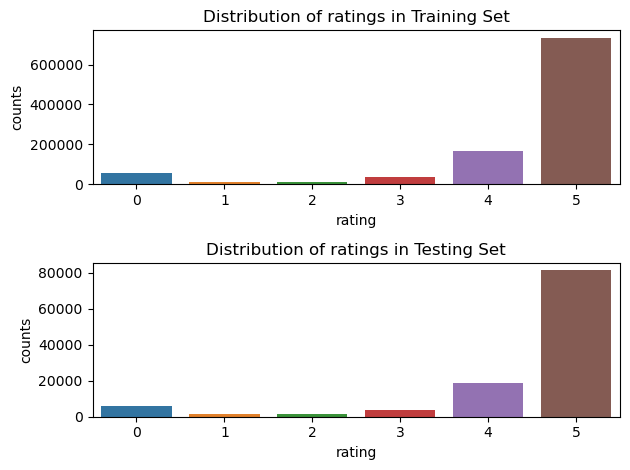

In [18]:
fig, axs = plt.subplots(2,1)
sns.barplot(data = ratings_count_TRAIN, x = ratings_count_TRAIN['rating'], y = ratings_count_TRAIN['counts'], ax = axs[0]).set(title='Distribution of ratings in Training Set');
sns.barplot(data = ratings_count_TEST, x = ratings_count_TEST['rating'], y = ratings_count_TEST['counts'], ax = axs[1]).set(title='Distribution of ratings in Testing Set');
plt.tight_layout()

In [20]:
interactions_TRAIN.head()

,user_id,recipe_id,date,rating,review
29040,59801,8060,2007-12-11,5,This really is a great basic meatball recipe. ...
63560,104295,38353,2005-02-08,5,Very yummy. I quartered the recipe and theref...
112640,58104,162999,2007-03-05,5,OK this may be a great Canadian drink! But whe...
3274,2000207498,2886,2015-05-16,5,Great recipe. I made a lot of changes though a...
125605,41695,27082,2002-06-10,4,"Very easy to make and I liked it, my kids didn..."


In [19]:
if not os.path.exists("./clean_data"):
    os.makedirs("./clean_data")

recipes.to_csv('./clean_data/recipes.csv')
interactions_TRAIN.to_csv('./clean_data/interactions_TRAIN.csv')
interactions_TEST.to_csv('./clean_data/interactions_TEST.csv')